In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
import warnings
warnings.filterwarnings("ignore")

# Q1
## Use of PERMNO vs. TICKERS:

PERMNO is a unique identifier assigned by the Center for Research in Security Prices (CRSP) to each security in the market. It is used in academic and research settings because it provides a consistent way to track securities over time, regardless of changes in ticker symbols, company names, or corporate actions such as mergers and acquisitions. This consistency is crucial for historical analysis over long periods, as it allows for the unambiguous identification of securities.

TICKERS, on the other hand, are symbols assigned to securities traded on public exchanges. These can change over time due to various reasons, such as rebranding, mergers, or moving between exchanges, which can create confusion in longitudinal studies.

The choice of PERMNO over tickers for the dataset is likely aimed at ensuring consistency and accuracy in tracking the performance and characteristics of securities over time, especially in a dataset that spans several years.

# Q2
## Discrepancies between One-Month Price Change and PRC Column:

a. This discrepancy is not necessarily a data error. The PRC column typically represents the end-of-month stock price, while the one-month percent change in price is calculated based on the price change from the previous month to the current month. Several factors can cause these numbers to diverge, including stock splits, dividends, and other corporate actions that affect the stock price but are not reflected in the simple price listed.

b. For some companies, these columns may always be equal due to the absence of such corporate actions during the period in question or because the stock's price changes purely reflect market trading without external adjustments. This uniformity could also be seen in companies with stable dividend policies or those that did not undergo any stock splits or similar adjustments during the period.

# Q3
## Variability in the Number of Companies:

The number of companies in the S&P 500 index does not always precisely equal 500 due to several factors, including mergers, acquisitions, bankruptcies, and the addition or removal of companies based on the market capitalization criteria set by the index. These events can cause the number of constituents to fluctuate temporarily until adjustments are made.

It's not a mistake but reflects the dynamic nature of the stock market and the index's composition adjustments to maintain its representation of the U.S. economy's leading companies.

# Q4

## 303 companies are present over the entire sample 
## 761 unique companies are in the sample

In [1]:
file_path = 'sp500raw.xlsx'
sp500_data = pd.read_excel(file_path)
sp500_data.drop(columns=['Unnamed: 0'], inplace =True)

display(sp500_data.head())

date_counts = sp500_data.groupby('permno').size()
full_presence_companies = date_counts[date_counts == sp500_data['date'].nunique()]

unique_companies = sp500_data['permno'].nunique()

(full_presence_companies.count(), unique_companies)

,permno,date,price,shrout,prc,mcap
0,43449,2011-01-31,73.67,1056507,-0.040255,77832870.69
1,13688,2011-01-31,46.28,392066,-0.032609,18144814.48
2,90071,2011-01-31,20.75,247197,0.061924,5129337.75
3,86580,2011-01-31,23.92,588556,0.553247,14078259.52
4,10225,2011-01-31,61.68,152581,0.023734,9411196.08


(303, 761)

# Q5



First, we plot the time series of market cap for all stocks each month

<Axes: title={'center': 'Different percentile for market cap'}, xlabel='date', ylabel='mcap'>

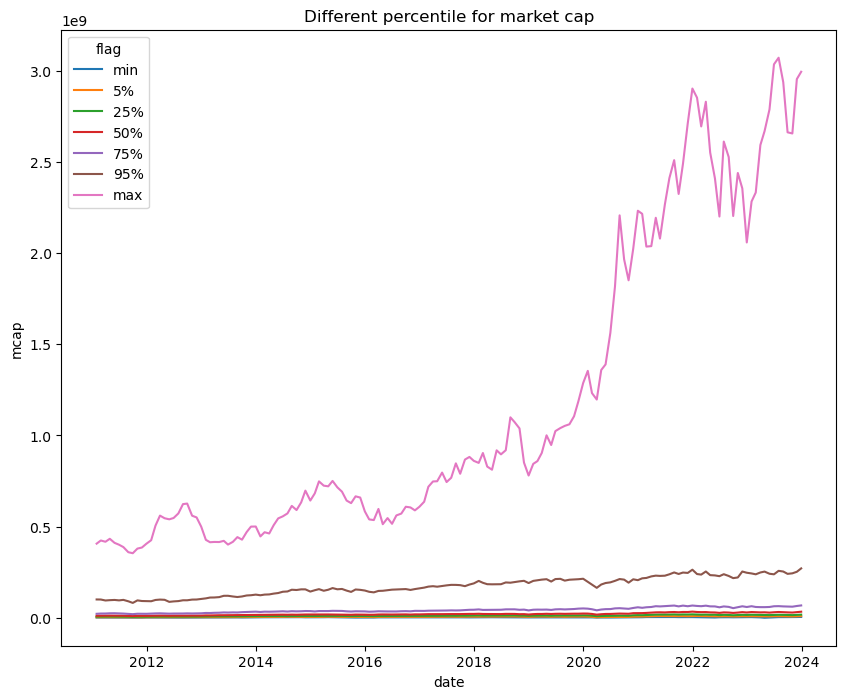

In [32]:
mcap_plot = sp500_data.groupby('date')['mcap'].describe(percentiles=[0.05,0.25,0.75,0.95]).reset_index()

col_plot = ['min', '5%', '25%', '50%', '75%', '95%','max']
df_list = []
for i in col_plot:
    tmp_df = mcap_plot[['date',i]]
    tmp_df['flag'] = i
    tmp_df.rename(columns={i:'mcap'},inplace=True)
    df_list.append(tmp_df)
mcap_final = pd.concat(df_list,axis=0)

plt.figure(figsize=(10,8))
plt.title('Different percentile for market cap')
sns.lineplot(data=mcap_final,x = 'date',y = 'mcap',hue='flag')


Calculate the percentile range for stock entering and leaving

In [63]:
sp500_data['rank'] = sp500_data.groupby(['date'])['mcap'].rank(ascending=True,pct=True)

first_mth = pd.DataFrame(sp500_data.groupby('permno')['date'].min()).reset_index()
last_mth = pd.DataFrame(sp500_data.groupby('permno')['date'].max()).reset_index()

first_mcap = pd.merge(first_mth,sp500_data[['permno','date','mcap','rank']],on=['permno','date'],how='left').rename(columns={'date':'first_date','mcap':'first_mcap','rank':'first_rank'})
last_mcap = pd.merge(last_mth,sp500_data[['permno','date','mcap','rank']],on=['permno','date'],how='left').rename(columns={'date':'last_date','mcap':'last_mcap','rank':'last_rank'})
mcap_each = pd.merge(first_mcap,last_mcap,on='permno',how='outer')
mcap_each

,permno,first_date,first_mcap,first_rank,last_date,last_mcap,last_rank
0,10104,2011-01-31,1.618290e+08,0.976000,2023-12-29,2.898188e+08,0.958250
1,10107,2011-01-31,2.329560e+08,0.996000,2023-12-29,2.794828e+09,0.998012
2,10137,2011-01-31,4.381027e+06,0.118000,2011-01-31,4.381027e+06,0.118000
3,10138,2011-01-31,1.705746e+07,0.672000,2023-12-29,2.406548e+07,0.399602
4,10145,2011-01-31,4.369749e+07,0.884000,2023-12-29,1.382515e+08,0.882704
...,...,...,...,...,...,...,...
756,93159,2012-07-31,1.260407e+07,0.536000,2016-02-29,2.039826e+06,0.005952
757,93246,2021-03-31,2.058384e+07,0.354455,2023-12-29,7.939472e+06,0.027833
758,93422,2011-01-31,7.137237e+06,0.282000,2015-06-30,3.269995e+06,0.001996
759,93429,2017-03-31,9.083326e+06,0.142574,2023-12-29,1.884808e+07,0.292247


Then we'll calculate the trailing return for each company

In [64]:
sp500_data_cal = sp500_data.copy()

In [66]:
sp500_data_cal.sort_values(by=['permno','date'],ascending=True,inplace=True)


,permno,date,price,shrout,prc,mcap,rank
48,10104,2011-01-31,32.03000,5052420,0.024920,1.618290e+08,0.976000
719,10104,2011-02-28,32.90000,5061000,0.027162,1.665069e+08,0.976000
1100,10104,2011-03-31,33.43250,5060516,0.016185,1.691857e+08,0.980000
1836,10104,2011-04-29,35.96000,5060516,0.077395,1.819762e+08,0.984000
2410,10104,2011-05-31,34.22000,5068000,-0.048387,1.734270e+08,0.980000
...,...,...,...,...,...,...,...
76191,93436,2023-08-31,258.07999,3173994,-0.034962,8.191443e+08,0.992048
76556,93436,2023-09-29,250.22000,3179000,-0.030456,7.954494e+08,0.992048
77248,93436,2023-10-31,200.84000,3178921,-0.197346,6.384545e+08,0.986083
77883,93436,2023-11-30,240.08000,3178921,0.195379,7.631954e+08,0.988072


In [73]:
sp500_data.reset_index(inplace=True)

In [84]:
sp500_data_cal['prc_shift'] = sp500_data_cal['prc'].shift()
sp500_data_cal['price_shift'] = sp500_data_cal['price'].shift()

In [133]:
PRC_Ret_T12 = pd.DataFrame((sp500_data_cal.groupby('permno')['prc'].rolling(12).apply(lambda x:np.prod(1 + x) - 1 , raw=True))).reset_index()
PRC_Ret_T12_result = pd.merge(PRC_Ret_T12,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

Prices_Ret_T12 = pd.DataFrame((sp500_data_cal.groupby('permno')['price'].rolling(12).apply(lambda x:x[-1] / x[0] - 1, raw=True))).reset_index()
Prices_Ret_T12_result = pd.merge(Prices_Ret_T12,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

In [98]:
PRC_Ret_T12M1 = pd.DataFrame((sp500_data_cal.groupby('permno')['prc_shift'].rolling(11).apply(lambda x:np.prod(1 + x) - 1 , raw=True))).reset_index()
PRC_Ret_T12M1_result = pd.merge(PRC_Ret_T12M1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

Prices_Ret_T12M1 = pd.DataFrame((sp500_data_cal.groupby('permno')['price_shift'].rolling(11).apply(lambda x:x[-1] / x[0] - 1, raw=True))).reset_index()
Prices_Ret_T12M1_result = pd.merge(Prices_Ret_T12M1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

In [147]:
PRC_Ret_T12_M1 = pd.DataFrame((sp500_data_cal.groupby('permno')['prc'].rolling(12).apply(lambda x:x[0] , raw=True))).reset_index()
PRC_Ret_T12_M1_result = pd.merge(PRC_Ret_T12_M1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')
Prices_Ret_T12_M1 = pd.DataFrame((sp500_data_cal.groupby('permno')['price'].rolling(13).apply(lambda x:x[1]/x[0]-1 , raw=True))).reset_index()
Prices_Ret_T12_M1_result = pd.merge(Prices_Ret_T12_M1,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

In [104]:
# Vol_Prices_Ret_T12M1 = Prices_Ret_T12M1_result.groupby('permno')['price_shift'].std()
Vol_Prices_Ret_T12M1 = pd.DataFrame(Prices_Ret_T12M1_result.groupby('permno')['price_shift'].std()).reset_index()

there exist some nan in volatility of Prices_Ret_T12M1 because the recording months are less than 12 months

In [114]:
SR_Prices_Ret_T12M1 = pd.merge(Vol_Prices_Ret_T12M1,Prices_Ret_T12M1_result[['permno','date','price_shift']],on='permno',how='right')
SR_Prices_Ret_T12M1['SR_Prices_Ret'] = SR_Prices_Ret_T12M1['price_shift_y']/SR_Prices_Ret_T12M1['price_shift_x']

Then calculate the forward return

In [130]:
sp500_data_cal['prc_shift-1'] = sp500_data_cal['prc'].shift(-1)
PRC_Ret_F1M_result = sp500_data_cal[['permno','date','prc_shift-1']]
PRC_Ret_F3M = pd.DataFrame((sp500_data_cal.groupby('permno')['prc'].rolling(3).apply(lambda x:np.prod(1 + x) - 1 , raw=True))).shift(-3).reset_index()
PRC_Ret_F3M_result = pd.merge(PRC_Ret_F3M,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')
PRC_Ret_F6M = pd.DataFrame((sp500_data_cal.groupby('permno')['prc'].rolling(6).apply(lambda x:np.prod(1 + x) - 1 , raw=True))).shift(-6).reset_index()
PRC_Ret_F6M_result = pd.merge(PRC_Ret_F6M,sp500_data[['level_0','permno','date']],left_on = ['permno','level_1'],right_on=['permno','level_0'],how = 'left')

In [151]:
result_df = SR_Prices_Ret_T12M1[['permno','date','SR_Prices_Ret']]
result_df['PRC_Ret_T12'] = PRC_Ret_T12_result['prc']
result_df['Prices_Ret_T12'] = Prices_Ret_T12_result['price']
result_df['PRC_Ret_T12M1'] = PRC_Ret_T12M1_result['prc_shift']
result_df['Prices_Ret_T12M1'] = Prices_Ret_T12M1_result['price_shift']
result_df['PRC_Ret_T12_M1'] = PRC_Ret_T12_M1_result['prc']
result_df['Prices_Ret_T12_M1'] = Prices_Ret_T12_M1_result['price']
result_df['PRC_Ret_F1M'] = PRC_Ret_F1M_result['prc_shift-1']
result_df['PRC_Ret_F3M'] = PRC_Ret_F3M_result['prc']
result_df['PRC_Ret_F6M'] = PRC_Ret_F6M_result['prc']

In [152]:
result_df

,permno,date,SR_Prices_Ret,PRC_Ret_T12,Prices_Ret_T12,PRC_Ret_T12M1,Prices_Ret_T12M1,PRC_Ret_T12_M1,Prices_Ret_T12_M1,PRC_Ret_F1M,PRC_Ret_F3M,PRC_Ret_F6M
0,10104,2011-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035564,0.124570,-0.041801
1,10104,2011-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004754,0.041857,-0.143709
2,10104,2011-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.036627,-0.013986,-0.137234
3,10104,2011-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.052676,-0.147942,-0.085250
4,10104,2011-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005999,-0.178110,-0.080391
...,...,...,...,...,...,...,...,...,...,...,...,...
78476,93436,2023-08-31,0.009455,-0.063603,-0.027031,-0.029678,0.008219,-0.037589,-0.037589,-0.029942,-0.069746,NaN
78477,93436,2023-09-29,0.154411,-0.056662,0.099675,-0.027030,0.134218,-0.142168,-0.142168,0.061608,-0.006954,NaN
78478,93436,2023-10-31,0.328059,-0.117340,0.031536,0.099676,0.285157,-0.144326,-0.144326,0.043382,NaN,NaN
78479,93436,2023-11-30,0.725313,0.233078,0.949018,0.031537,0.630459,-0.367334,-0.367334,0.080934,NaN,NaN


# Q6

plot the time series of different variables

In [154]:
var_list = ['SR_Prices_Ret', 'PRC_Ret_T12', 'Prices_Ret_T12',
       'PRC_Ret_T12M1', 'Prices_Ret_T12M1', 'PRC_Ret_T12_M1',
       'Prices_Ret_T12_M1', 'PRC_Ret_F1M', 'PRC_Ret_F3M', 'PRC_Ret_F6M']

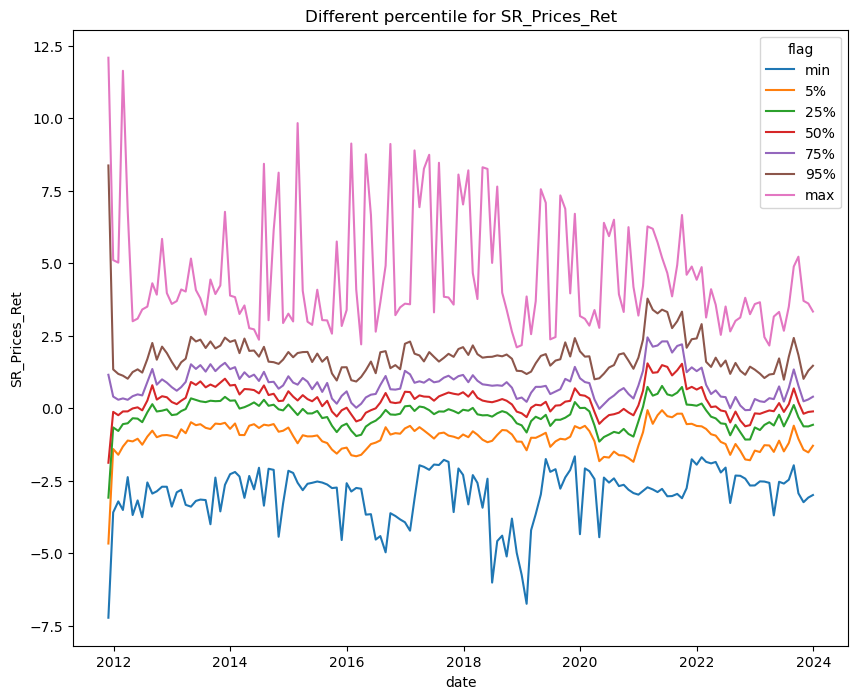

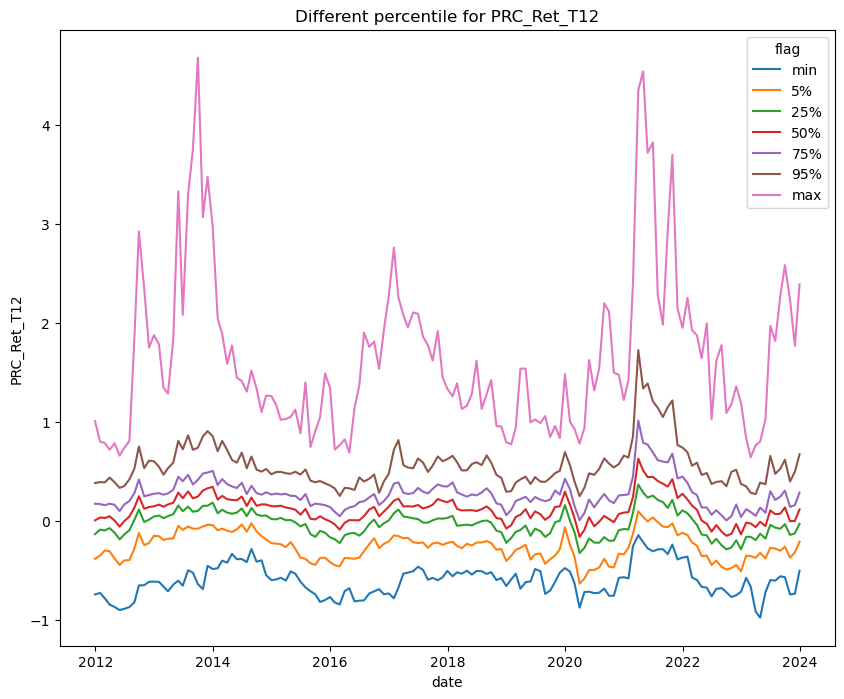

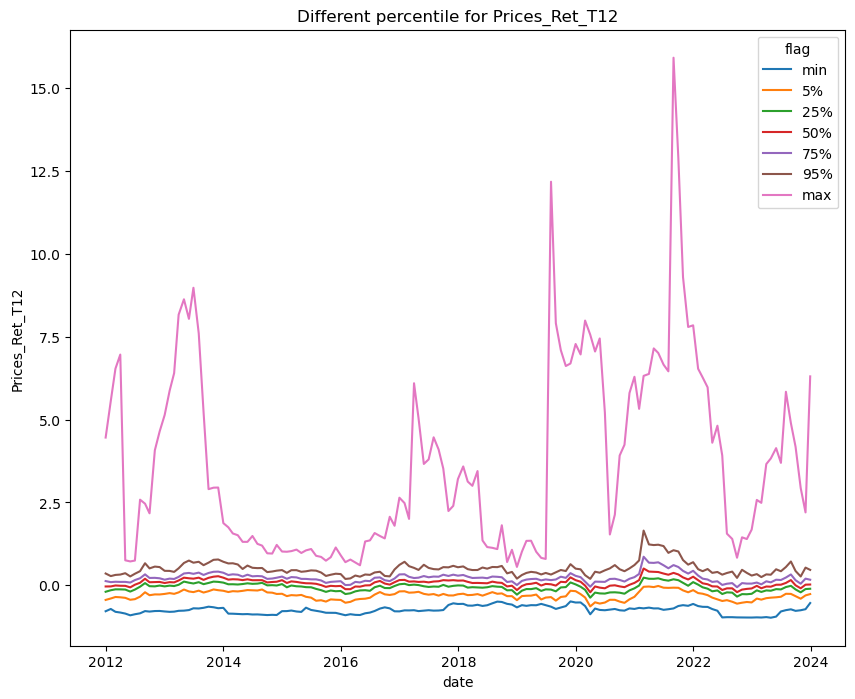

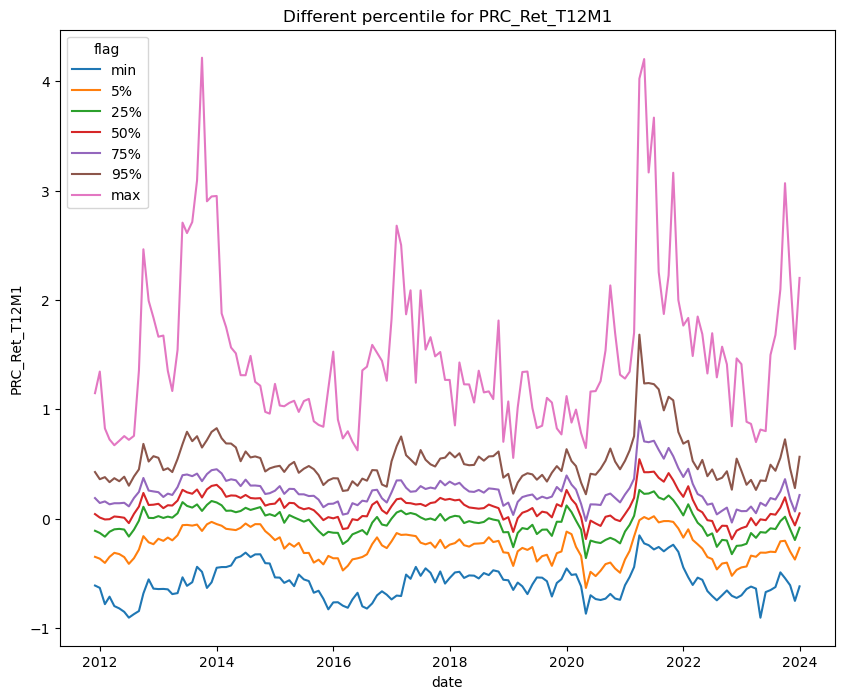

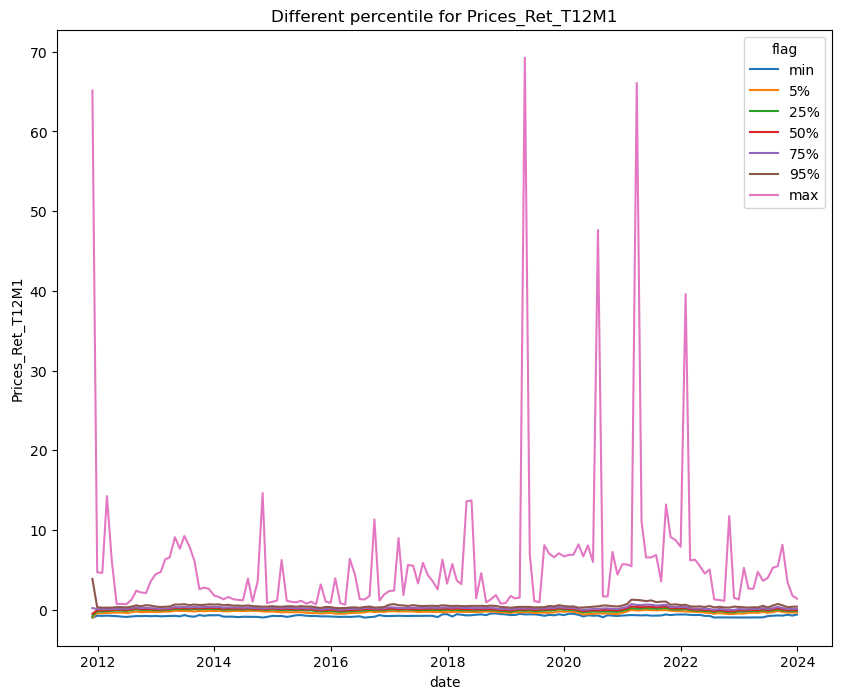

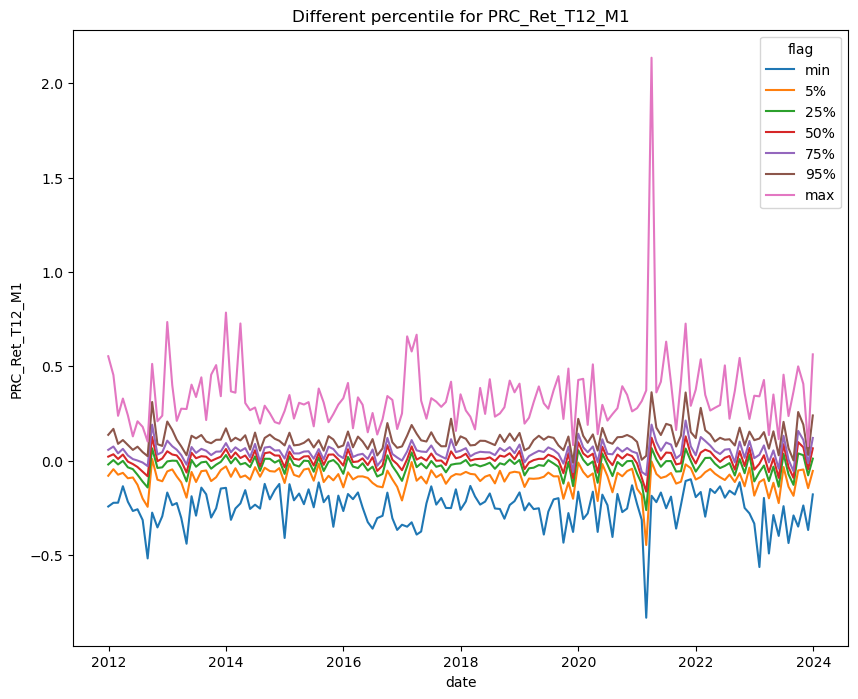

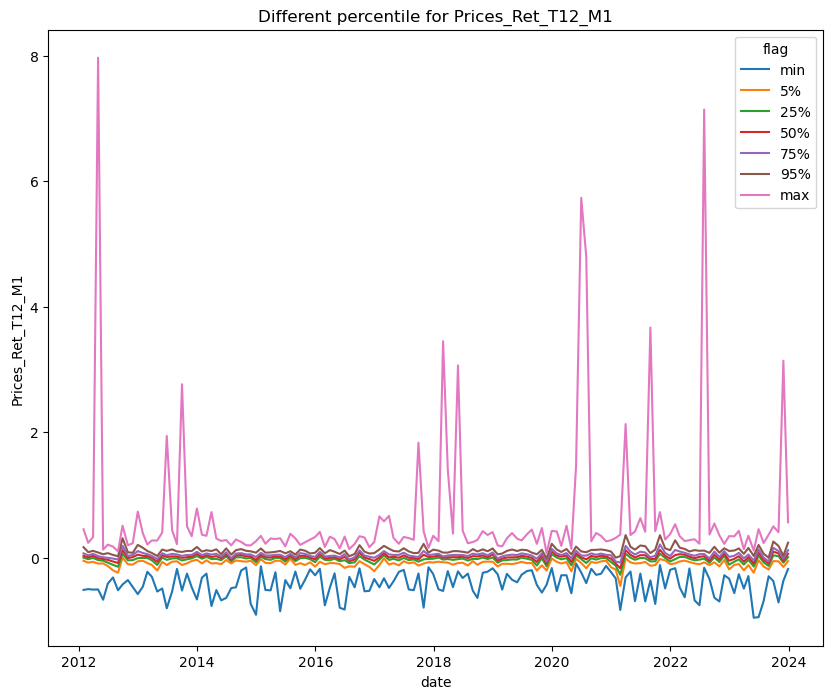

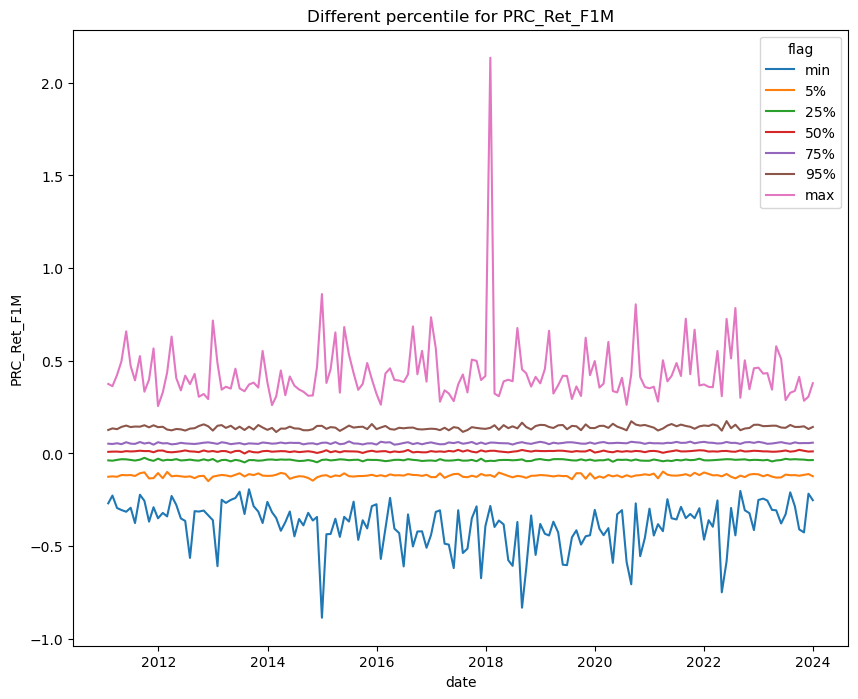

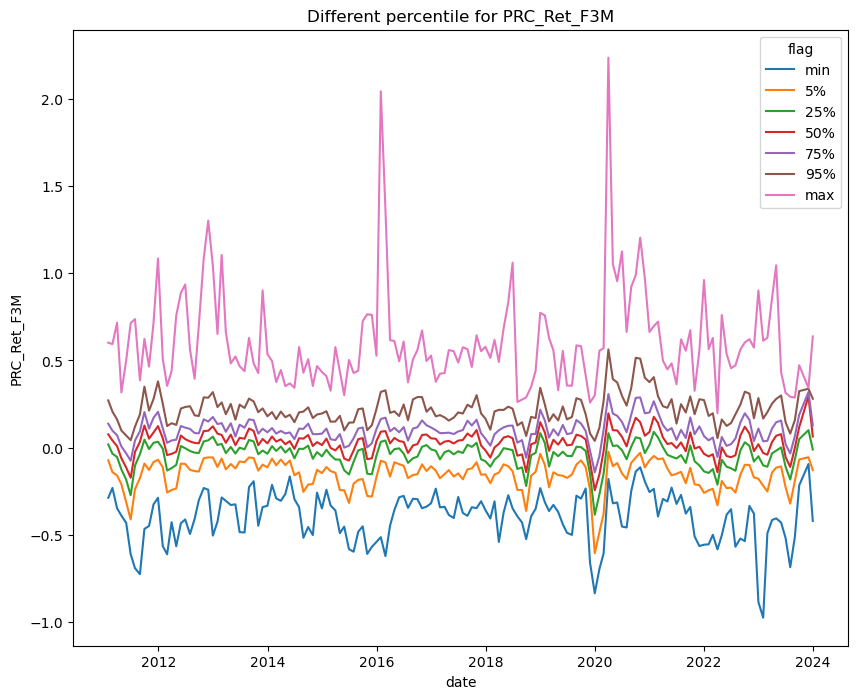

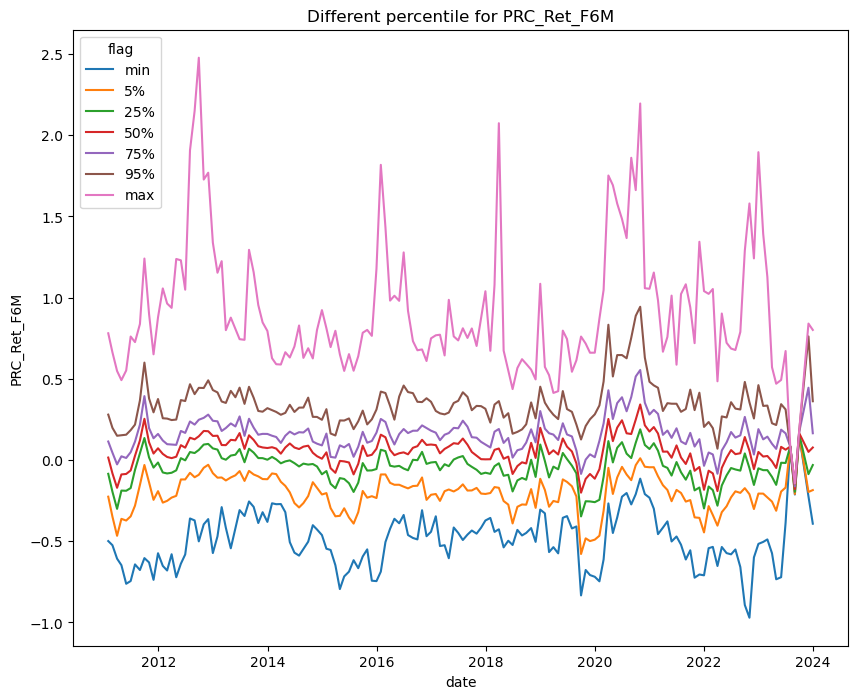

In [159]:

for j in var_list:
    var_plot = result_df.groupby('date')[j].describe(percentiles=[0.05,0.25,0.75,0.95]).reset_index()

    col_plot = ['min', '5%', '25%', '50%', '75%', '95%','max']
    df_list = []
    for i in col_plot:
        tmp_df = var_plot[['date',i]]
        tmp_df['flag'] = i
        tmp_df.rename(columns={i:j},inplace=True)
        df_list.append(tmp_df)
    var_final = pd.concat(df_list,axis=0)
    cleaned_df = var_final.dropna()
    # print(var_final)
    plt.figure(figsize=(10,8))
    plt.title(f'Different percentile for {j}')
    # print(j)
    sns.lineplot(data=cleaned_df,x = 'date',y = j,hue='flag')
